# Panoptic segmentation using DETR

In this notebook we demonstrate how to explore the panoptic segmentation capabilities of DETR. The prediction occurs in several steps: 

1.   The model predicts a box and a binary mask for each object queries
2.   We filter the predictions for which the confidence is < 85%
3.   Finally, the remaining masks are merged together using a pixel-wise argmax

For simplicity, we rely on DETR's postprocessor to execute 2 and 3. We encourage to take a look at the corresponding code to get a better understanding of the process.

Finally, we visualize the final prediction using Detectron2.

## Preliminaries

This section contains the necessary boiler-plate. Run it first.

In [1]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False)

/home/alexander/Documents/Programming/ObjectDetection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The panoptic API is required for panoptic inference

In [11]:
! pip install git+https://github.com/cocodataset/panopticapi.git

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-cfr65o_2
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-cfr65o_2
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8260 sha256=53a4c570555344315508c99db3b3c7e608d8081e87e18b54873e897bcf5f6633
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0ja4b7v/wheels/70/87/ae/5c2b138c967549070e3fe35f3b5fcaf1ed56e9f5483a09ee65
Successfully built panopticapi

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [25]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [2]:
# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



## Using a model from hub

We load a pre-trained model directly from torch hub. Note that we also request the post-processor

In [4]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model = model.eval()

Using cache found in /home/alexander/.cache/torch/hub/facebookresearch_detr_main


Next, we retrieve an image on which we wish to test the model. Here, we use an image from the validation set of COCO

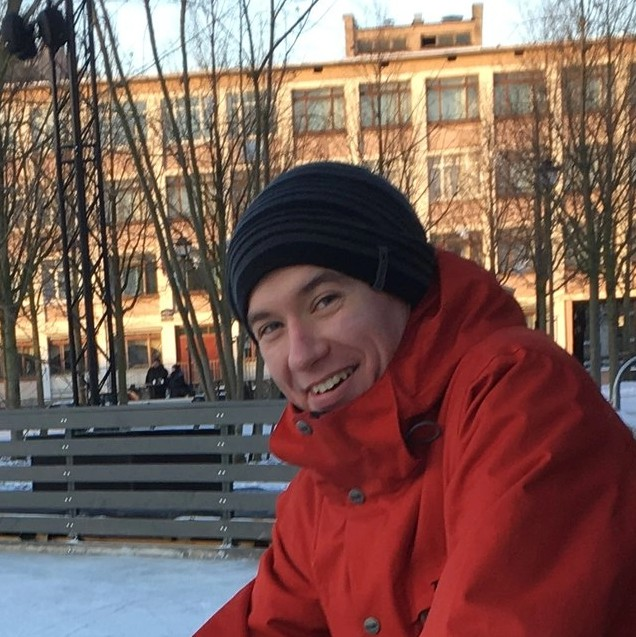

In [41]:
# url = "http://images.cocodataset.org/val2017/000000281759.jpg"
# im = Image.open(requests.get(url, stream=True).raw)

path = '../data/images/0je5b4V4MQ0_1.jpg'
im = Image.open(path) #.resize((240,240))

im

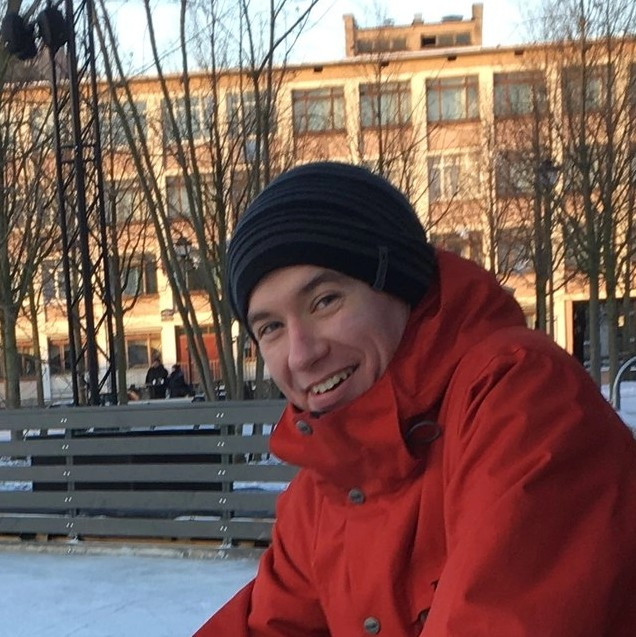

In [67]:
import cv2
im2 = cv2.imread('../data/images/0je5b4V4MQ0_1.jpg')
im2 = Image.fromarray(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
im2

Finally, we run the prediction

In [6]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
out = model(img)

This returns a mask for each query, let us visualize the high confidence ones

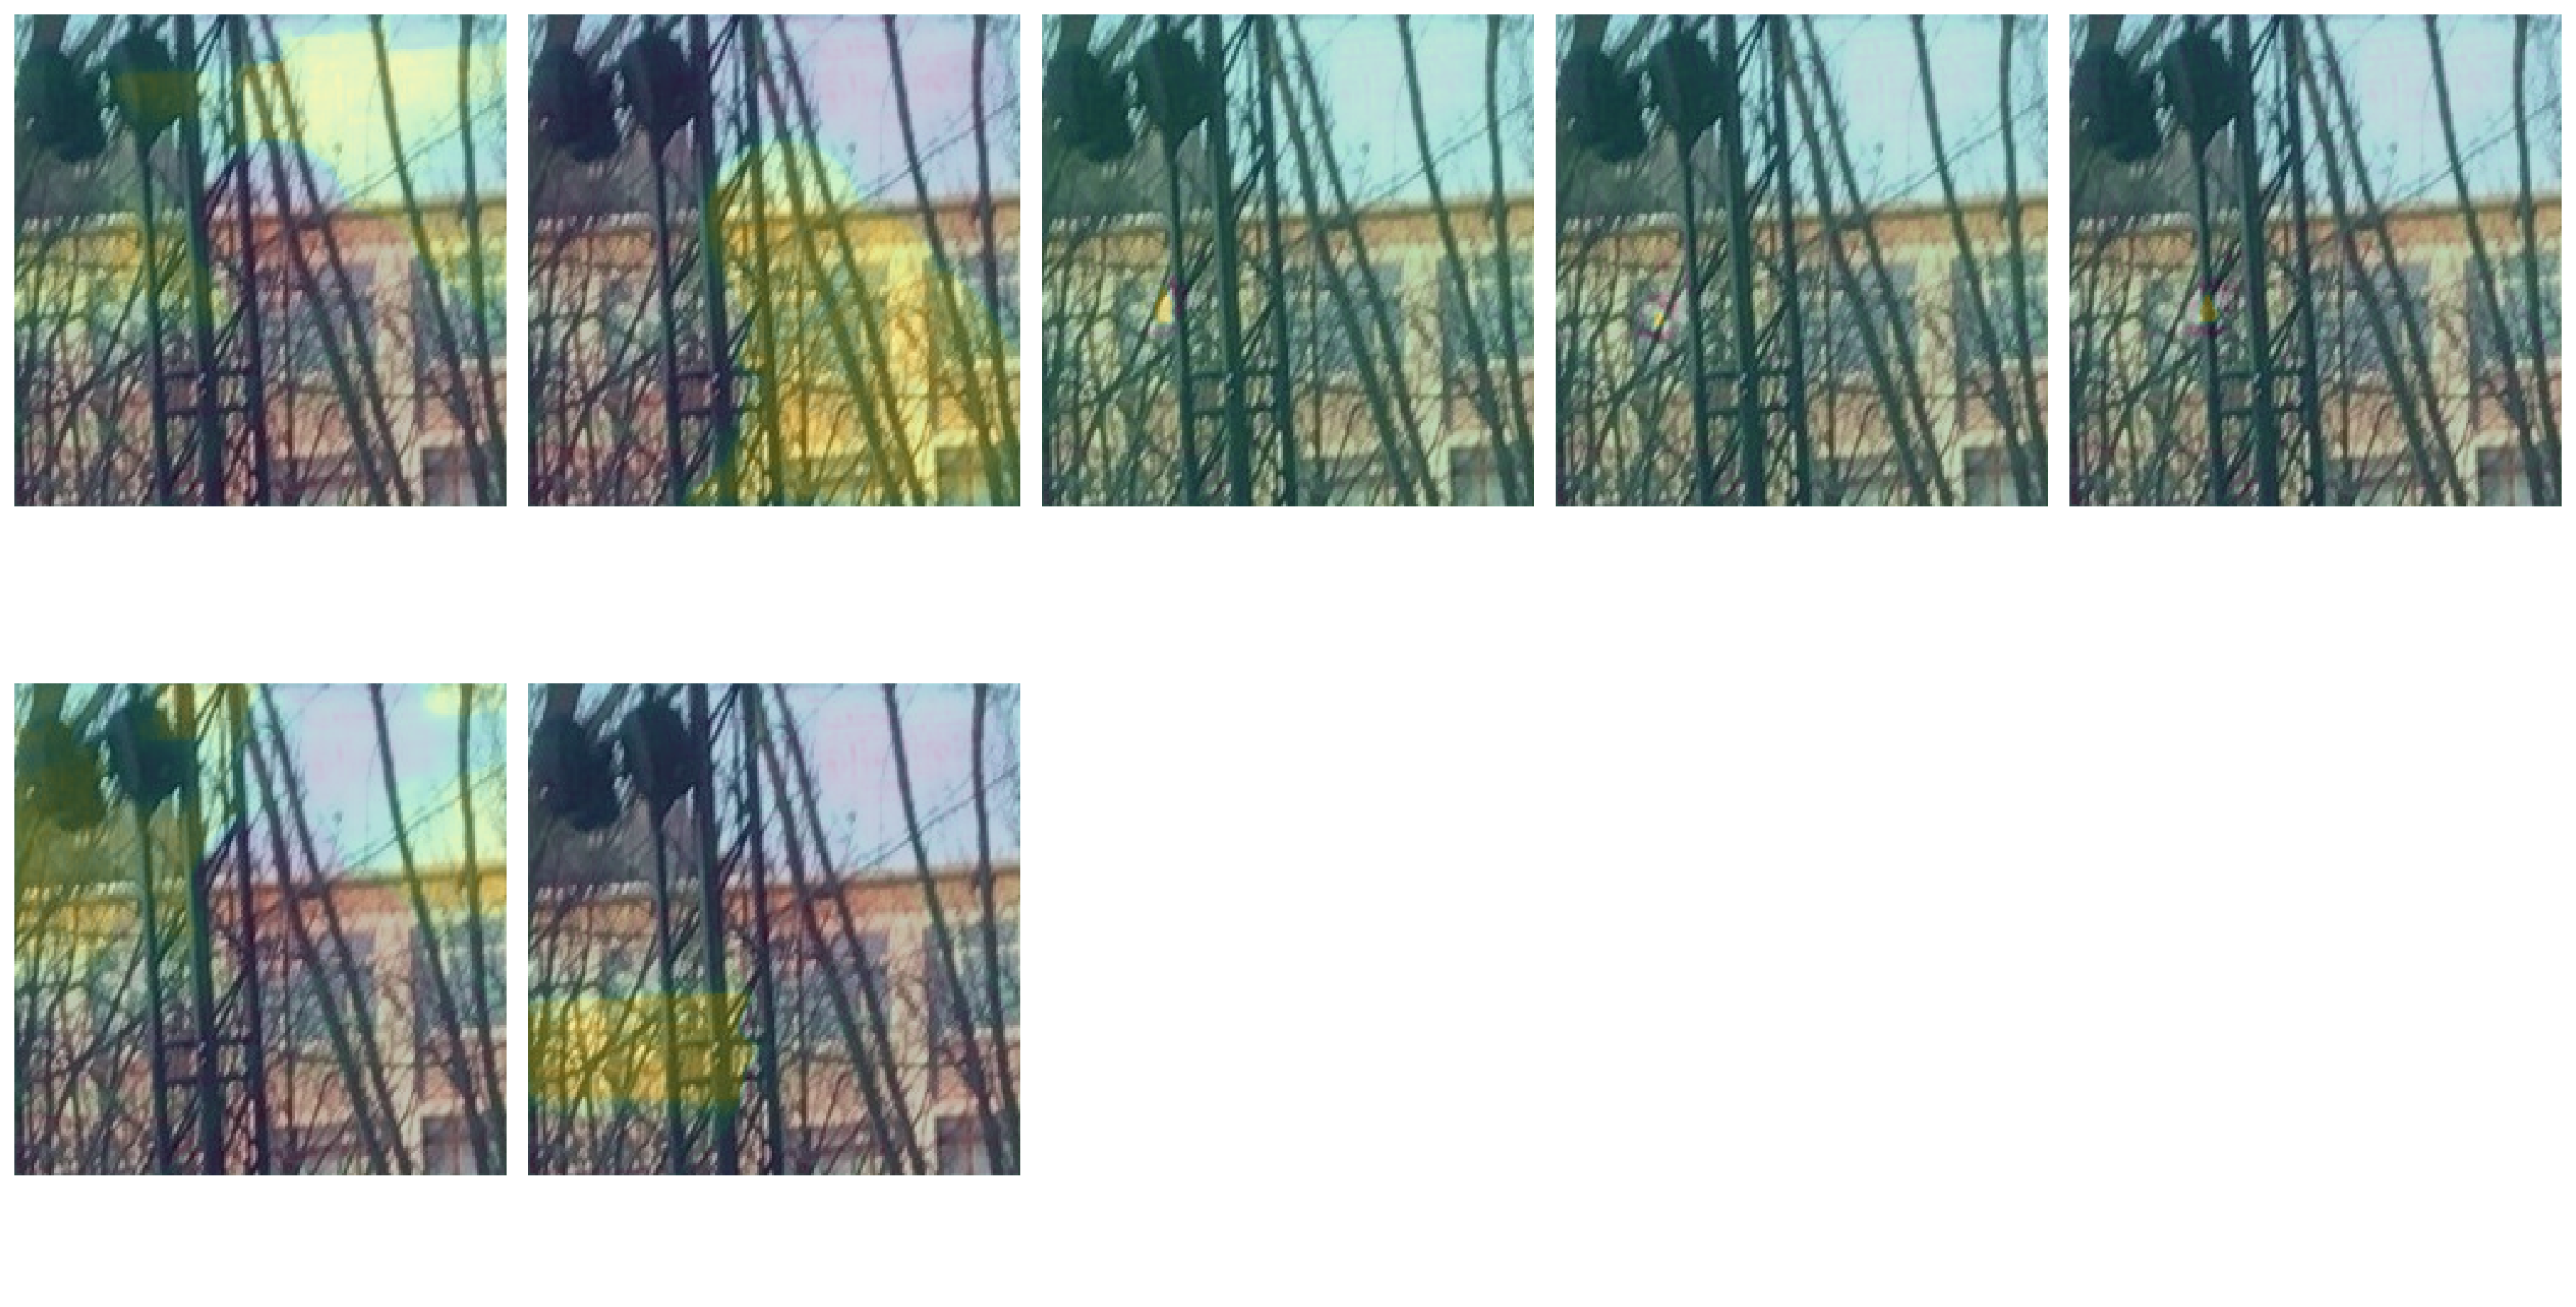

In [68]:
# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    # mask = mask * torch.Tensor([800])
    # mask=cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    # mask_out=cv2.subtract(mask, im2)
    # mask_out=cv2.subtract(mask, mask_out)
    # ax.imshow(mask_out)
    ax.imshow(im2)
    ax.imshow(mask, alpha=0.3)
    ax.axis('off')
fig.tight_layout()

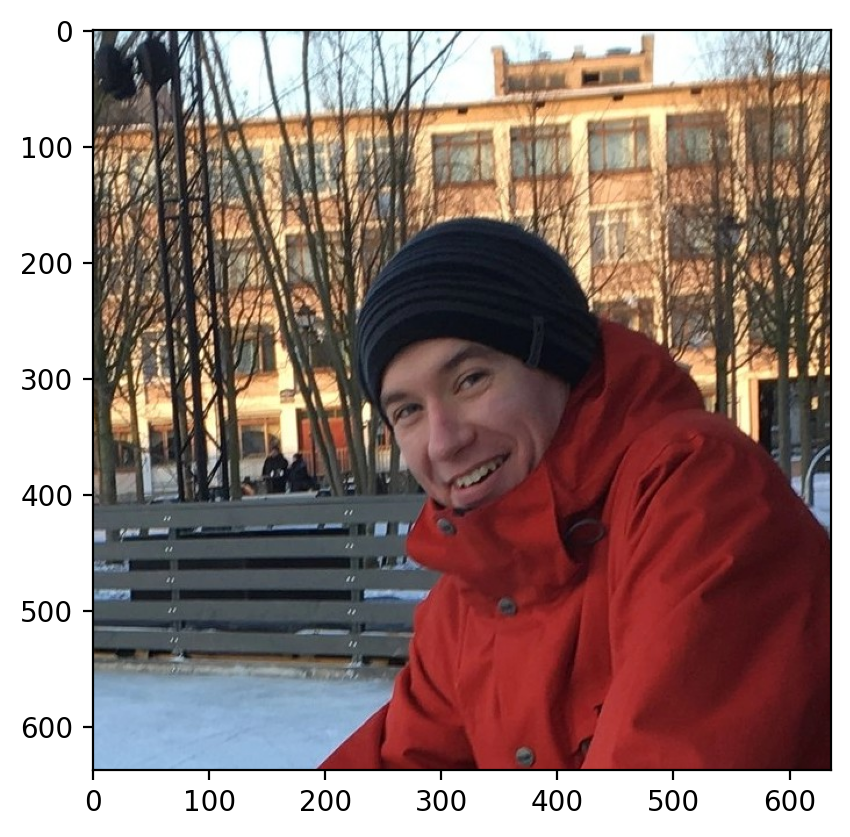

In [43]:
# fig, ax = plt.figure(figsize=(5,5))
# fig.plot(out["pred_masks"][0][1])
plt.imshow(im2)

In [18]:
# import cv2
# mask = out["pred_masks"][0][1].numpy()
# mask=cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)#change mask to a 3 channel image 
# mask_out=cv2.subtract(mask, img)
# mask_out=cv2.subtract(mask, mask_out)

In [33]:
from PIL import Image, ImageDraw
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import numpy as np
# im2 = im.copy()
draw = ImageDraw.Draw(im)
for logits, box, mask in zip(out['pred_logits'][0], out['pred_boxes'][0], out["pred_masks"][0]):
    cls = logits.argmax()
    if cls >= len(CLASSES):
        continue
    label = CLASSES[cls]
    if label == 'person':
        box = box * torch.Tensor([800,800,800,800])
        x, y, w, h = box
        x0, x1 = x - w//2, x + w//2
        y0, y1 = y - h//2, y + h//2
        # draw.bitmap([x0, y0, x1, y1],mask)
        # draw_segmentation_masks(im2, masks=mask, alpha=0.6)
        draw.rectangle([x0, y0, x1, y1], outline='blue', width=2)
        draw.text((x0+5, y0+2), label, fill='red')     


AttributeError: 'Tensor' object has no attribute 'load'

Now that we have the individual masks, we can merge the predictions into a unified panoptic segmentation. We use DETR's postprocessor for that.



In [81]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

NameError: name 'id2rgb' is not defined

We can now do a simple visualization of the result

In [27]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

NameError: name 'result' is not defined

## Panoptic visualization using Detectron2

In this section we demonstrate how to obtain a better looking visualization by leveraging Detectron2's plotting utilities.

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
# !pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


Finally, we visualize it

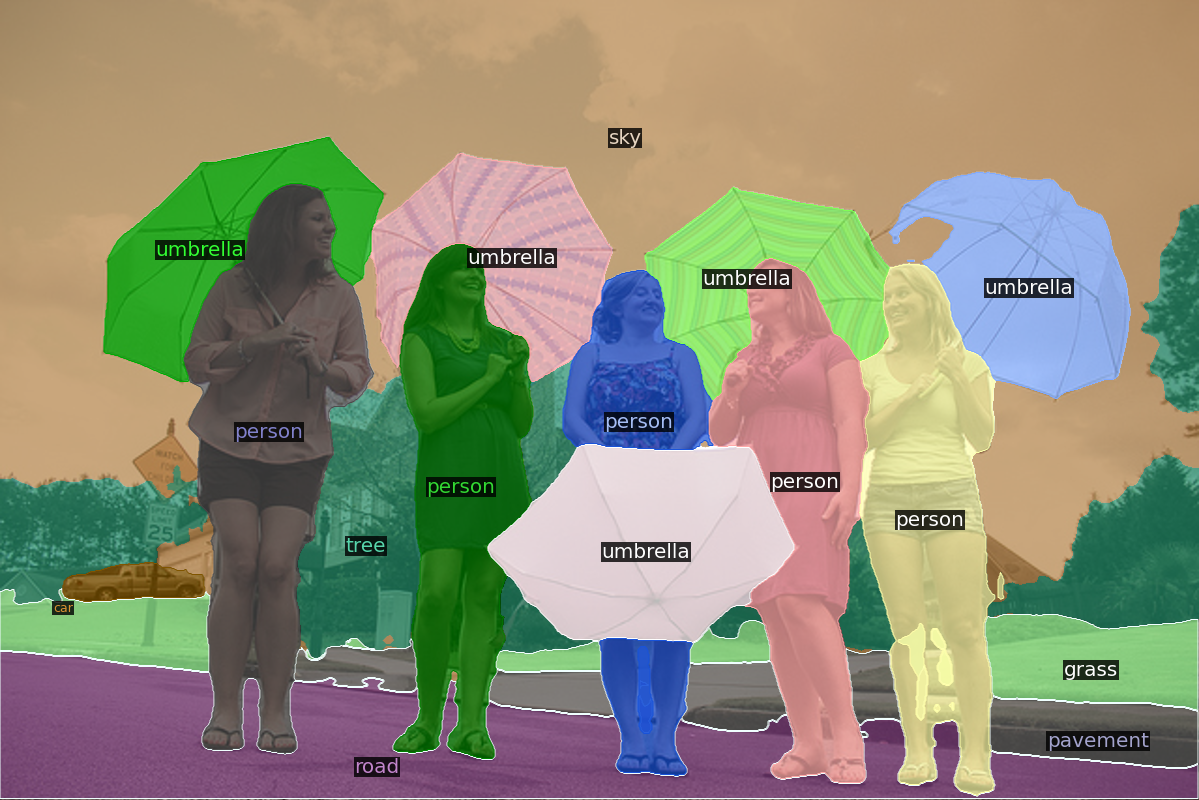

In [ ]:
from copy import deepcopy
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

    
    
# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
cv2_imshow(v.get_image())